# Video pipeline with Yolo + Resnet Model

In [1]:
import os
import sys
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
from typing import Dict, List
import numpy as np

pp = PrettyPrinter(indent=4)
from barazmoon.twitter import twitter_workload_generator

# get an absolute path to the directory that contains parent files
__file__ = globals()["_dh"][0]
project_dir = __file__ = globals()["_dh"][0]
sys.path.append(os.path.normpath(os.path.join(project_dir, "..", "..", "..")))

from experiments.utils.constants import FINAL_RESULTS_PATH
from experiments.utils.parser import AdaptationParser
from experiments.utils.drawing import draw_temporal, draw_cumulative

In [2]:
serieses = [2152, 2153, 2154]
series_names = None
# series_names = {203: "IPA", 204: "FA2", 205: "RIM"}

series_paths = {
    series: os.path.join(FINAL_RESULTS_PATH, "series", str(series))
    for series in serieses
}

loaders = {
    series: AdaptationParser(
        series_path=series_path, model_name="video", type_of="router_pipeline"
    )
    for series, series_path in series_paths.items()
}

In [3]:
loaders

{2152: <experiments.utils.parser.AdaptationParser at 0x7f40942abb80>,
 2153: <experiments.utils.parser.AdaptationParser at 0x7f4095378ca0>,
 2154: <experiments.utils.parser.AdaptationParser at 0x7f40942b6850>}

In [4]:
accuracy_methods = {}
adaptation_intervals = {}
simulation_modes = {}
configs = {}
for series, loader in loaders.items():
    configs_exp = loader.load_configs()
    print(f"series: {series} config:\n")
    config = configs_exp["0.yaml"]
    pp.pprint(config)
    configs[series] = config
    accuracy_methods[series] = config["accuracy_method"]
    adaptation_intervals[series] = config["adaptation_interval"]
    simulation_modes[series] = config["simulation_mode"]

series: 2152 config:

{   'accuracy_method': 'sum',
    'adaptation_interval': 10,
    'allocation_mode': 'base',
    'alpha': 2,
    'backup_predictor_duration': 2,
    'backup_predictor_type': 'max',
    'baseline_mode': None,
    'batching_cap': 64,
    'benchmark_duration': 1,
    'beta': 1,
    'central_queue': True,
    'debug_mode': False,
    'distrpution_time': 30,
    'drop_limit': 10,
    'gamma': 10,
    'initial_active_model': ['yolov5n', 'resnet18'],
    'initial_batch': [1, 1],
    'initial_cpu_allocation': [1, 1],
    'initial_replica': [1, 1],
    'latency_margin': 0,
    'logs_enabled': True,
    'metadata': 'doubling the load',
    'mode': 'exponential',
    'model_name': ['yolo', 'resnet-human'],
    'monitoring_duration': 2,
    'nodes': [   {   'cpu_request': '1',
                     'data_type': 'image',
                     'max_batch_size': '1',
                     'max_batch_time': '1',
                     'memory_request': '2Gi',
                     'mode

In [5]:
# load the sent workload
sent_loads = {}
for series, config in configs.items():
    workload_type = config["workload_type"]
    workload_config = config["workload_config"][0]
    start = workload_config["start"]
    end = workload_config["end"]
    damping_factor = workload_config["damping_factor"]
    sent_loads[series] = twitter_workload_generator(
        days=f"{start}-{end}", damping_factor=damping_factor
    )

In [6]:
# key_config_df = loader.loader.key_config_mapper()
# display(key_config_df)
# key_config_df.columns
results_all = []
simulation_modes

{2152: False, 2153: False, 2154: False}

In [7]:
adaptation_logs = dict(
    map(lambda l: (l[0], l[1].load_adaptation_log()), loaders.items())
)

In [8]:
series_changes = {}
for series in serieses:
    series_changes[series] = loaders[series].series_changes(
        adaptation_log=adaptation_logs[series]
    )

## Comparing Predicted Load with the Recieved Load

[5, 3, 5, 5, 7, 5, 4, 5, 7, 5, 4, 4, 4, 4, 6, 4, 4, 6, 4, 3, 6, 5, 6, 5, 5, 4, 4, 6, 5, 4, 6, 5, 6, 5, 6, 7, 7, 5, 5, 4, 7, 6, 6, 5, 4, 6, 6, 4, 6, 5, 4, 4, 4, 5, 5, 5, 3, 5, 5, 6, 8, 10, 7, 6, 5, 6, 6, 5, 6, 6, 4, 6, 6, 3, 7, 6, 6, 4, 6, 6, 5, 6, 6, 3, 7, 4, 5, 6, 6, 5, 5, 5, 5, 8, 5, 5, 6, 6, 5, 7, 7, 7, 7, 6, 4, 5, 5, 4, 6, 5, 5, 7, 5, 5, 6, 6, 5, 6, 5, 6, 5, 5, 5, 6, 5, 6, 5, 6, 5, 6, 5, 4, 5, 5, 6, 5, 5, 6, 4, 4, 5, 5, 5, 4, 4, 6, 6, 16, 15, 12, 12, 15, 15, 18, 21, 16, 21, 20, 22, 24, 24, 21, 23, 22, 23, 23, 27, 26, 22, 25, 24, 26, 26, 24, 23, 22, 27, 24, 23, 25, 26, 24, 26, 30, 27, 27, 28, 30, 27, 24, 24, 24, 24, 29, 27, 25, 29, 28, 27, 25, 26, 28, 33, 25, 27, 29, 27, 29, 27, 28, 28, 27, 26, 26, 27, 28, 26, 25, 29, 30, 24, 28, 27, 29, 26, 26, 25, 27, 31, 27, 26, 29, 24, 28, 27, 27, 28, 27, 31, 26, 28, 29, 31, 24, 28, 28, 29, 29, 33, 28, 27, 28, 26, 28, 27, 25, 27, 28, 26, 26, 29, 29, 28, 25, 27, 28, 28, 26, 25, 27, 30, 28, 31, 26, 29, 30, 27, 30, 25, 34, 31, 26, 32, 28, 28, 25, 2

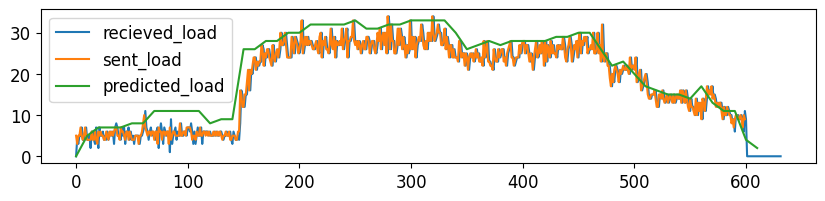

[10, 7, 10, 10, 14, 11, 8, 11, 15, 10, 9, 9, 9, 8, 12, 9, 8, 13, 8, 7, 12, 11, 12, 11, 11, 8, 9, 12, 10, 8, 13, 11, 12, 10, 12, 14, 14, 11, 10, 8, 15, 13, 13, 10, 9, 12, 12, 9, 12, 11, 9, 9, 9, 10, 11, 10, 7, 11, 11, 13, 16, 20, 14, 13, 10, 12, 12, 11, 12, 13, 8, 12, 12, 7, 14, 13, 12, 9, 13, 12, 11, 13, 12, 7, 14, 9, 10, 12, 13, 11, 11, 11, 11, 16, 11, 11, 13, 12, 11, 15, 14, 15, 15, 13, 9, 10, 11, 9, 12, 11, 10, 14, 11, 11, 12, 13, 10, 13, 11, 13, 11, 10, 10, 13, 10, 13, 11, 13, 11, 12, 11, 9, 10, 11, 13, 11, 11, 12, 9, 9, 10, 10, 11, 8, 9, 12, 12, 33, 31, 25, 25, 30, 30, 36, 42, 33, 42, 41, 45, 48, 49, 42, 47, 44, 46, 47, 54, 52, 45, 50, 48, 52, 53, 49, 46, 45, 54, 48, 46, 51, 53, 48, 52, 61, 55, 54, 57, 61, 54, 49, 49, 48, 48, 58, 54, 50, 58, 57, 54, 51, 53, 57, 66, 51, 55, 59, 55, 59, 54, 57, 56, 55, 53, 53, 55, 56, 53, 51, 58, 60, 49, 57, 54, 58, 53, 53, 50, 55, 62, 54, 52, 59, 48, 57, 54, 54, 57, 55, 62, 52, 56, 59, 63, 49, 56, 56, 58, 59, 66, 56, 54, 56, 53, 57, 55, 51, 54, 57,

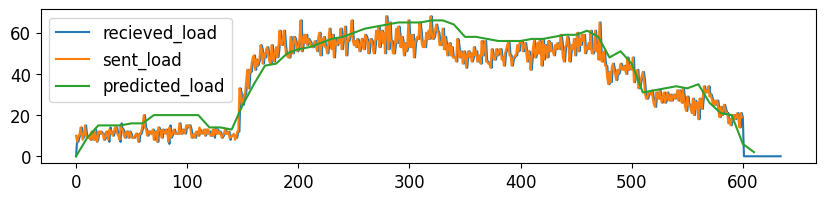

[20, 14, 21, 21, 28, 22, 17, 23, 31, 20, 18, 19, 19, 16, 24, 19, 16, 26, 16, 14, 24, 23, 24, 23, 23, 17, 19, 25, 20, 17, 27, 23, 25, 20, 25, 29, 29, 23, 21, 16, 30, 27, 26, 21, 19, 25, 25, 19, 24, 22, 18, 19, 19, 21, 22, 20, 15, 22, 22, 26, 32, 41, 29, 27, 20, 25, 24, 22, 24, 26, 16, 24, 25, 14, 29, 27, 25, 19, 26, 25, 22, 27, 24, 14, 29, 19, 20, 24, 26, 23, 23, 22, 22, 32, 23, 23, 26, 24, 23, 30, 28, 31, 30, 26, 19, 20, 23, 19, 25, 23, 21, 28, 23, 23, 24, 26, 21, 26, 23, 27, 23, 21, 21, 27, 20, 26, 22, 26, 23, 25, 22, 18, 20, 23, 27, 23, 23, 24, 19, 19, 20, 20, 23, 16, 19, 24, 25, 66, 62, 51, 51, 60, 60, 72, 85, 66, 84, 82, 91, 96, 98, 84, 94, 88, 92, 94, 109, 104, 91, 101, 97, 105, 107, 98, 93, 90, 108, 96, 93, 102, 106, 96, 105, 122, 111, 109, 114, 123, 108, 98, 98, 96, 97, 116, 109, 101, 116, 114, 108, 103, 107, 114, 132, 102, 110, 119, 111, 119, 109, 114, 112, 111, 106, 106, 111, 113, 106, 102, 116, 121, 98, 115, 109, 117, 106, 107, 101, 110, 125, 108, 104, 118, 96, 115, 108, 108,

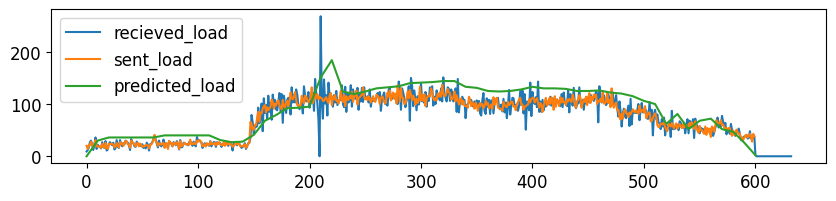

In [9]:
for series, series_dict in series_changes.items():
    recieved_load = series_changes[series]["recieved_load"]
    predicted_load = series_changes[series]["predicted_load"]
    # recieved_load = [int(item) for item in recieved_load if item != 0]
    recieved_load_x = [x for x in range(0, len(recieved_load))]
    sent_load_x = [x for x in range(0, len(sent_loads[series]))]
    predicted_load_x = series_changes[series]["time_interval"]

    print(sent_loads[series])
    print(recieved_load)

    print(len(sent_loads[series]))
    print(len(recieved_load))
    plt.figure(figsize=(10, 2))
    plt.plot(recieved_load_x, recieved_load, label="recieved_load")
    plt.plot(sent_load_x, sent_loads[series], label="sent_load")
    plt.plot(predicted_load_x, predicted_load, label="predicted_load")
    # TODO add predicted reference load here
    plt.legend()
    plt.show()

    # print(50 * "-" + f" {series} " + 50 * "-")
    # recieved_load = series_changes[series]["recieved_load"]
    # # recieved_load = [int(item) for item in recieved_load if item != 0]
    # recieved_load_x = [x for x in range(0, len(recieved_load))]
    # sent_load_x = [x for x in range(0, len(sent_loads[series]))]
    # print(sent_loads[series])
    # print(recieved_load)

    # print(len(sent_loads[series]))
    # print(len(recieved_load))
    # plt.figure(figsize=(10, 2))
    # plt.plot(recieved_load_x, recieved_load, label="recieved_load")
    # plt.plot(sent_load_x, sent_loads[series], label="sent_workload")
    # # TODO add predicted reference load here
    # plt.legend()
    # plt.show()

## Replica Changes
1. Total
2. Per node

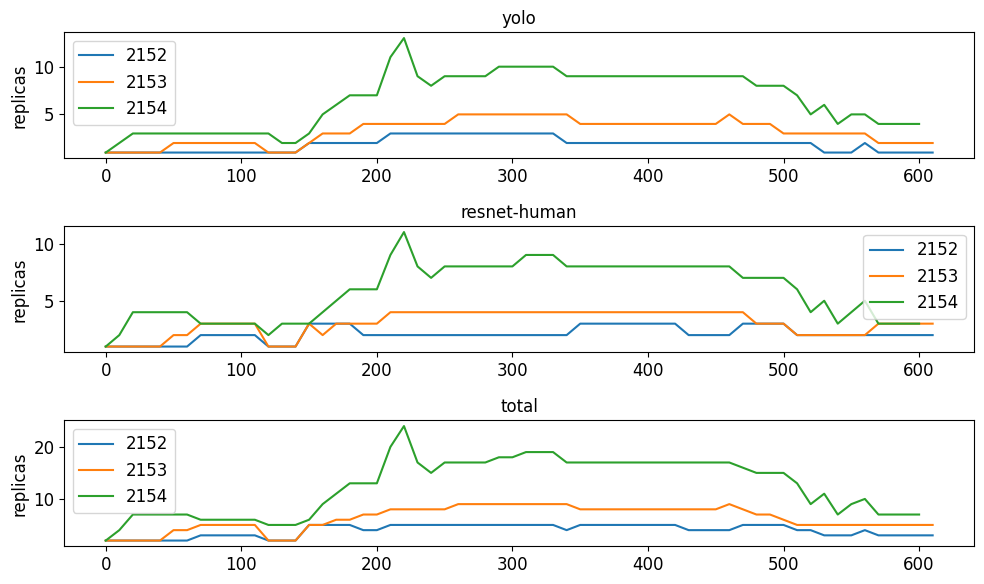

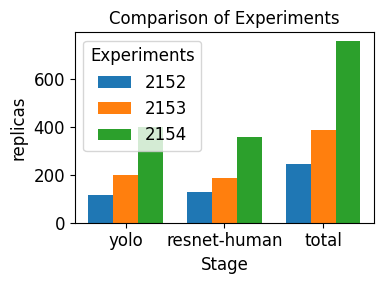

In [10]:
replica_changes = {}
for series, series_dict in series_changes.items():
    # print(50 * "-" + f" {series} " + 50 * "-")
    replica_changes[series] = {}
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        replica_changes[series][node_name] = metrics["replicas"]
        nodes.append(node_name)
    # replica_changes['total'] = []
    replica_changes[series]["total"] = [
        sum(x) for x in zip(*replica_changes[series].values())
    ]
    # draw_temporal(replica_changes[series], adaptation_intervals[series])
ylabel = "replicas"
draw_temporal(
    replica_changes, adaptation_intervals, ylabel=ylabel, multiple_experiments=True
)
draw_cumulative(replica_changes, multiple_experiments=True, ylabel=ylabel)

## Per Container Core changes
1. Total
2. Per Node

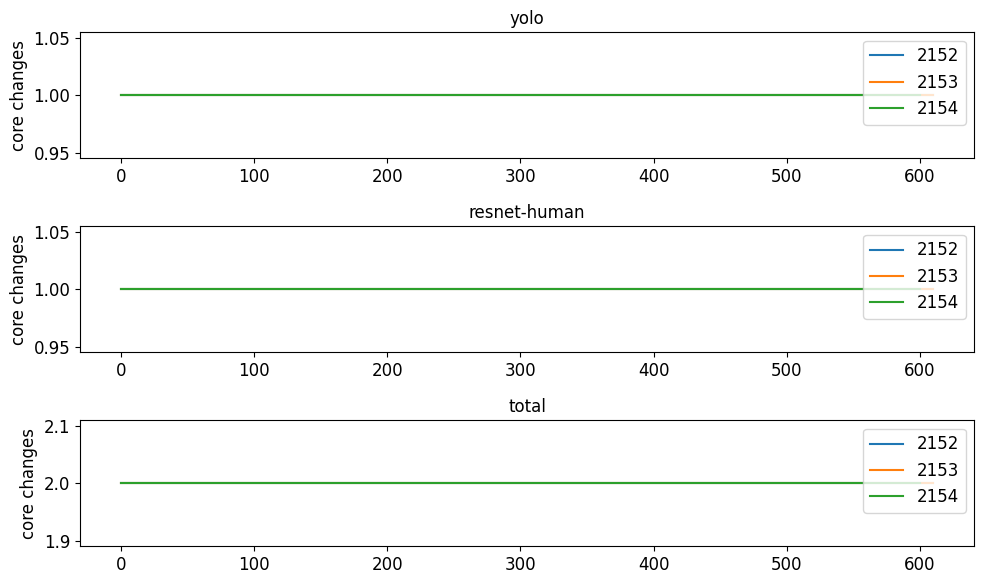

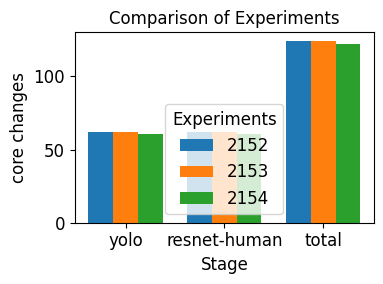

In [11]:
core_changes = {}
for series in serieses:
    # print(50 * "-" + f" {series} " + 50 * "-")
    core_changes[series] = {}
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        core_changes[series][node_name] = metrics["cpu"]
        nodes.append(node_name)
    core_changes[series]["total"] = [
        sum(x) for x in zip(*core_changes[series].values())
    ]
    # draw_temporal(core_changes[series])
ylabel = "core changes"
draw_temporal(
    core_changes, adaptation_intervals, multiple_experiments=True, ylabel=ylabel
)

draw_cumulative(
    core_changes, multiple_experiments=True, ylabel=ylabel, series_names=series_names
)

## Total core changes
replica * cores for each stage
1. Total
2. Per Node

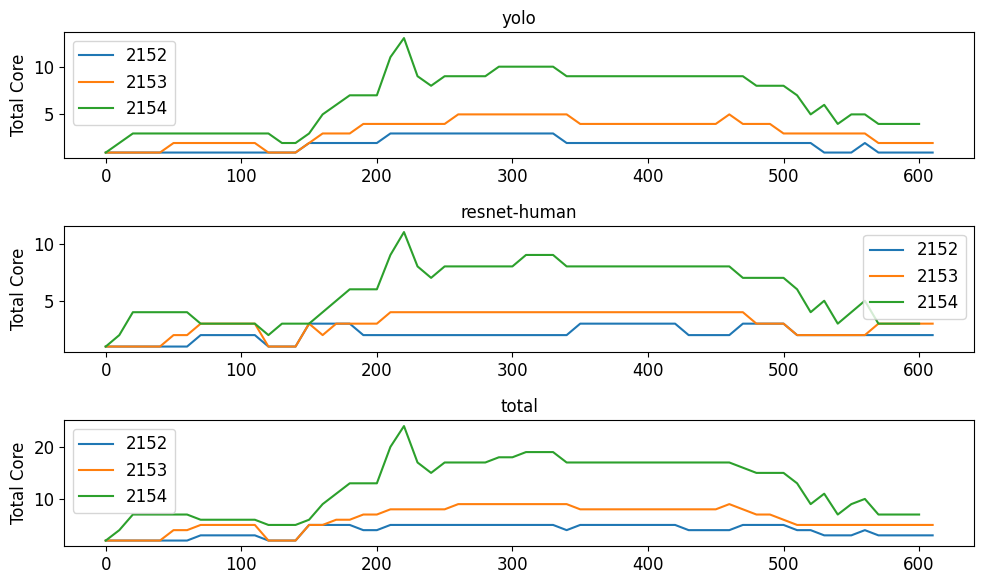

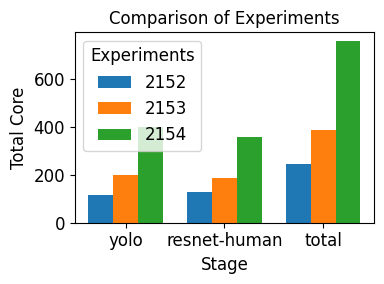

In [12]:
total_core_changes = {}
for series in serieses:
    # print(50 * "-" + f" {series} " + 50 * "-")
    total_core_changes[series] = {}
    for key in replica_changes[series].keys():
        if key != "total":
            total_core_changes[series][key] = [
                x * y
                for x, y in zip(replica_changes[series][key], core_changes[series][key])
            ]
    total = np.zeros(len(list(total_core_changes[series].values())[0]))
    for key, series_value  in total_core_changes[series].items():
        total += np.array(series_value)
    total_core_changes[series]['total'] = total.tolist() 
    # draw_temporal(total_core_changes[series])
ylabel = "Total Core"
draw_temporal(
    total_core_changes, adaptation_intervals, multiple_experiments=True, ylabel=ylabel
)
draw_cumulative(
    total_core_changes,
    multiple_experiments=True,
    ylabel=ylabel,
    series_names=series_names,
)

## Accuracy Changes

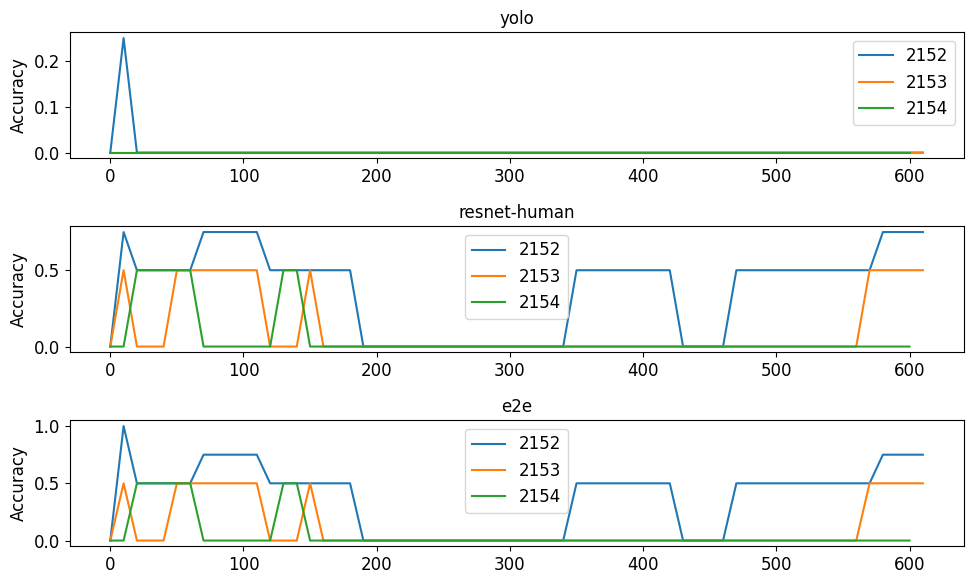

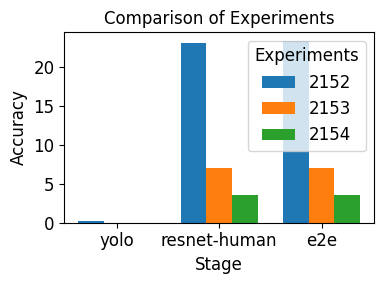

In [13]:
accuracy_changes = {}
for series in serieses:
    accuracy_changes[series] = {}
    # print(50 * "-" + f" {series} " + 50 * "-")
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        accuracy_changes[series][node_name] = metrics["accuracy"]
        nodes.append(node_name)
    # replica_changes['total'] = []
    if accuracy_methods[series] == "sum":
        accuracy_changes[series]["e2e"] = [
            sum(x) for x in zip(*accuracy_changes[series].values())
        ]
    # draw_temporal(accuracy_changes[series])
ylabel = "Accuracy"
draw_temporal(
    accuracy_changes, adaptation_intervals, multiple_experiments=True, ylabel=ylabel
)
draw_cumulative(accuracy_changes, multiple_experiments=True, ylabel=ylabel, series_names=series_names)

## Batching Changes

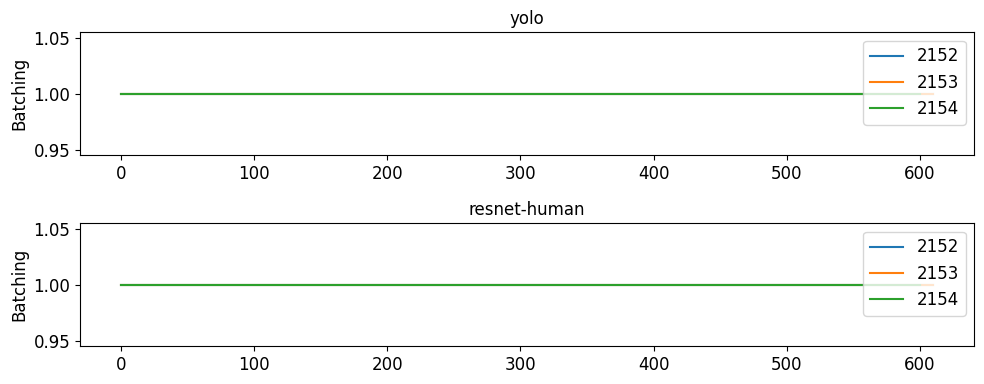

In [14]:
batching_changes = {}
for series in serieses:
    batching_changes[series] = {}
    # print(50 * "-" + f" {series} " + 50 * "-")
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        batching_changes[series][node_name] = metrics["batch"]
        nodes.append(node_name)
    # replica_changes['total'] = []
    # batching_changes['total'] = [sum(x) for x in zip(*batching_changes.values())]
    # draw_temporal(batching_changes[series])
ylabel = "Batching"
draw_temporal(
    batching_changes, adaptation_intervals, multiple_experiments=True, ylabel=ylabel
)
# draw_cumulative(batching_changes, multiple_experiments=True, ylabel=ylabel)

# Expected Throughput

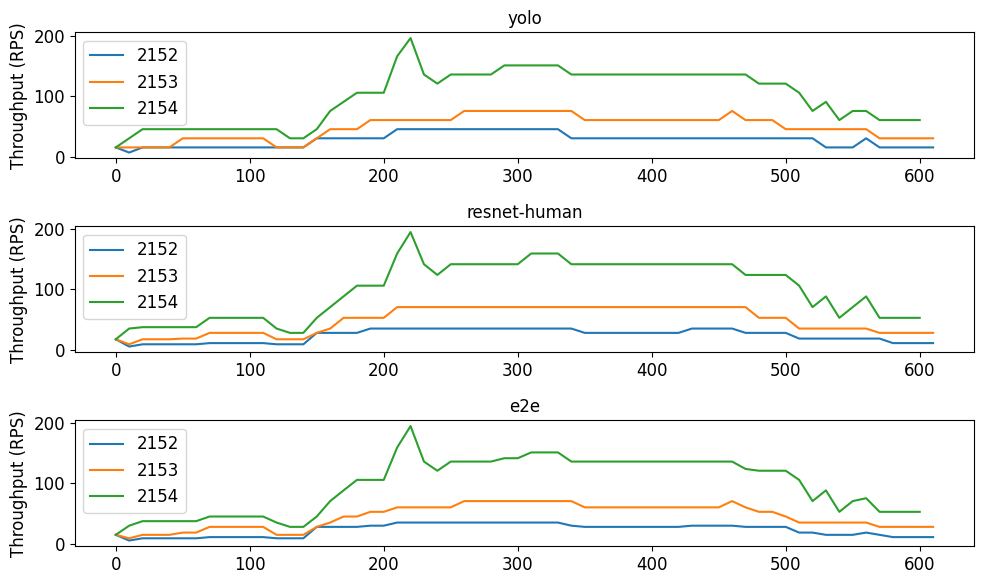

In [15]:
throughput_changes = {}
for series in serieses:
    throughput_changes[series] = {}
    # print(50 * "-" + f" {series} " + 50 * "-")
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        throughput_changes[series][node_name] = metrics["throughput"]
        nodes.append(node_name)
    # replica_changes['total'] = []
    throughput_changes[series]["e2e"] = [
        min(x) for x in zip(*throughput_changes[series].values())
    ]
    # draw_temporal(throughput_changes[series])
ylabel = "Throughput (RPS)"
draw_temporal(
    throughput_changes, adaptation_intervals, multiple_experiments=True, ylabel=ylabel
)
# draw_cumulative(throughput_changes, multiple_experiments=True, ylabel=ylabel)

## Expected Latency

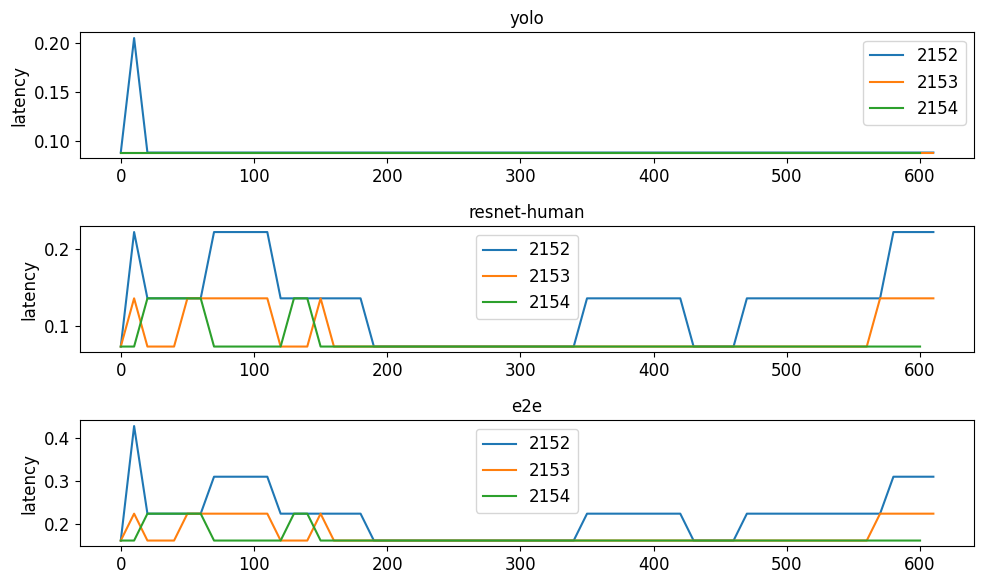

In [16]:
latency_changes = {}
for series in serieses:
    latency_changes[series] = {}
    # print(50 * "-" + f" {series} " + 50 * "-")
    nodes = []
    for node_name, metrics in series_changes[series]["nodes"].items():
        latency_changes[series][node_name] = metrics["latency"]
        nodes.append(node_name)
    # replica_changes['total'] = []
    latency_changes[series]["e2e"] = [
        sum(x) for x in zip(*latency_changes[series].values())
    ]
    # draw_temporal(latency_changes[series])
ylabel = "latency"
draw_temporal(
    latency_changes, adaptation_intervals, multiple_experiments=True, ylabel=ylabel
)
# draw_cumulative(latency_changes, multiple_experiments=True, ylabel=ylabel)

# Real Latencies

## Maeseured p99 Latency


In [17]:
timeout_per_second = {}
per_second_results = {}
for series in serieses:
    if not simulation_modes[series]:
        timeout_per_second[series], per_second_results[series] = loaders[
            series
        ].per_second_result_processing()
    else:
        timeout_per_second[series], per_second_results[series] = None, None

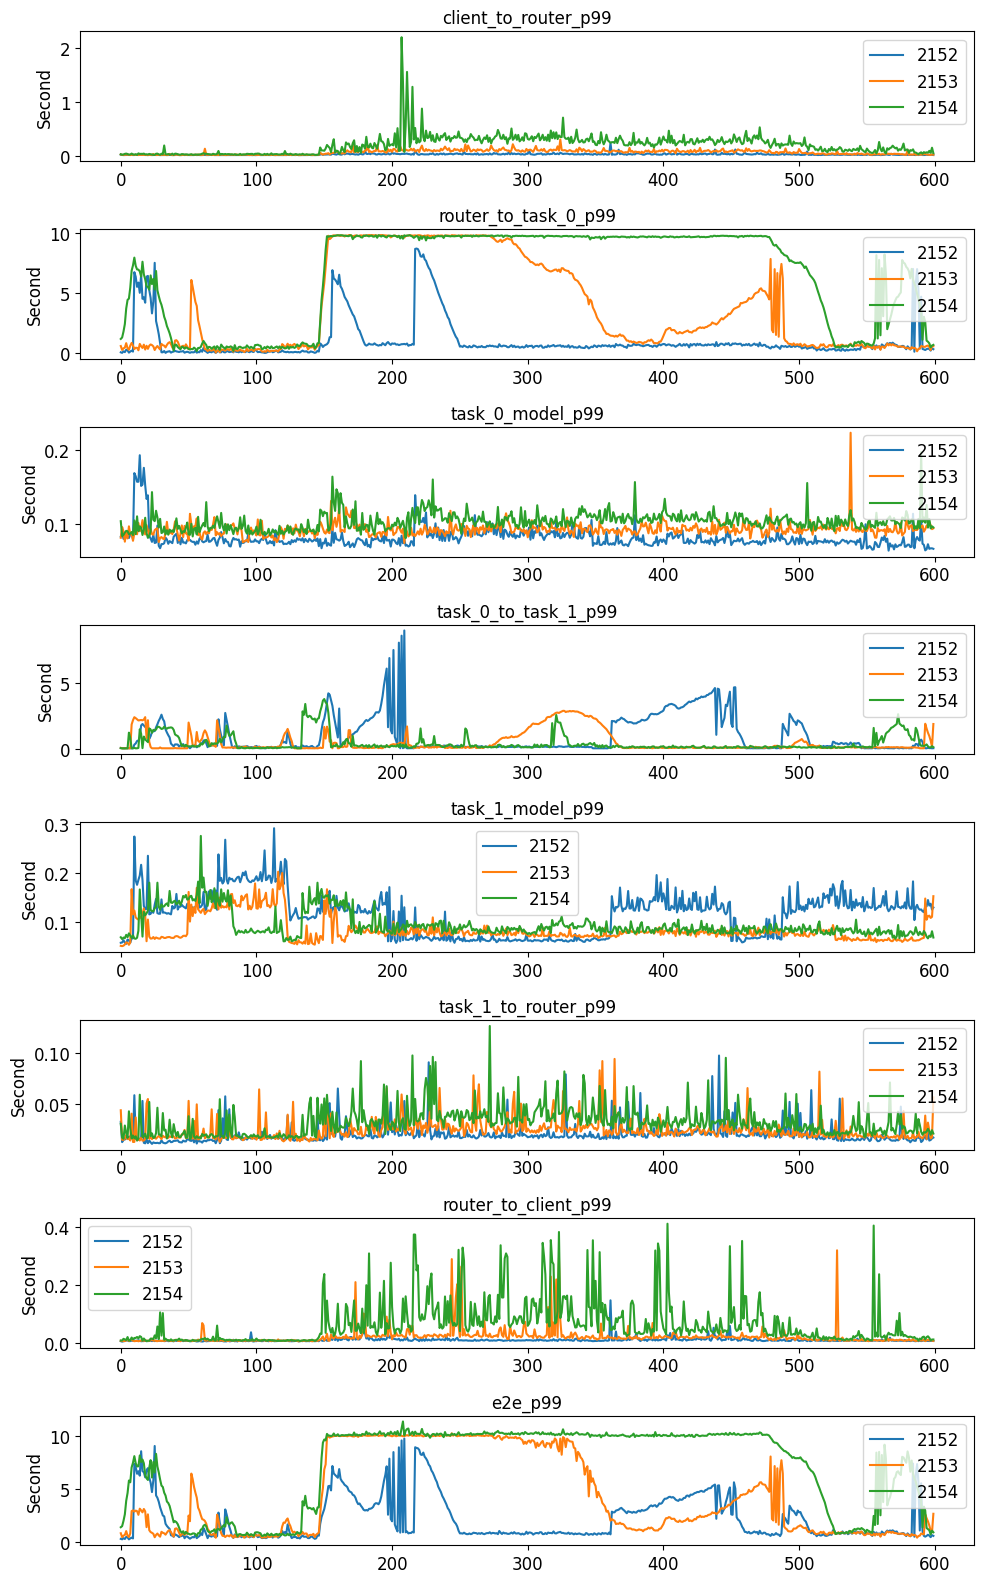

In [18]:
if not all(simulation_modes.values()):
    metric = "p99"  # [min, max, p99]
    metrics_all = {}
    for series in serieses:
        # print(50 * "-" + f" {series} " + 50 * "-")
        if not simulation_modes[series]:
            metric_columns = list(
                filter(lambda col: metric in col, per_second_results[series].columns)
            )
            metrics_all[series] = per_second_results[series][metric_columns]
            # metrics_all[series][f"{metric}_e2e"] = metrics_all[series].sum(axis=1).to_list()
            metrics_all[series] = metrics_all[series].to_dict(orient="list")
            # draw_temporal(metrics_all[series])
    ylabel = "Second"
    draw_temporal(metrics_all, multiple_experiments=True, ylabel=ylabel)
    # draw_cumulative(metrics_all, multiple_experiments=True, ylabel=ylabel)

# Every point a change was triggered

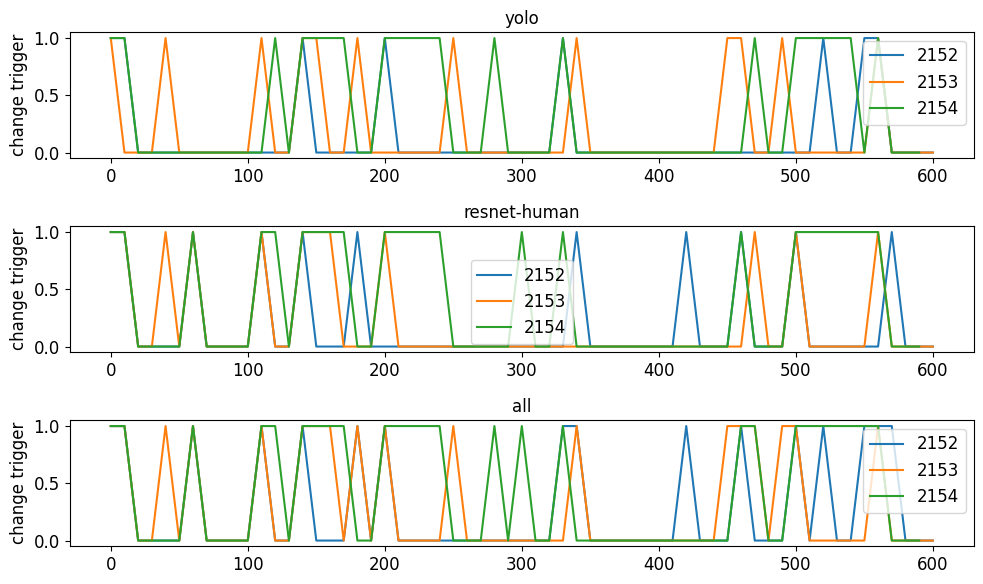

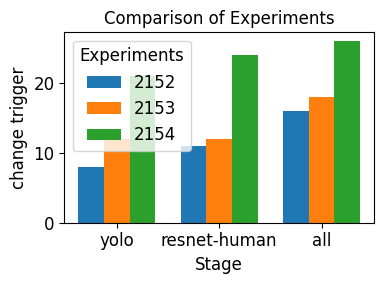

In [19]:
change_trigger = {}
for series in serieses:
    change_trigger[series] = {}
    # print(50 * "-" + f" {series} " + 50 * "-")
    change_trigger[series] = loader.points_with_change(
        adaptation_log=adaptation_logs[series]
    )
    change_trigger[series]["all"] = [
        any(x) for x in zip(*change_trigger[series].values())
    ]
    # draw_temporal(change_trigger[series], adaptation_interval=adaptation_intervals[series])
ylabel = "change trigger"
draw_temporal(
    change_trigger, adaptation_intervals, multiple_experiments=True, ylabel=ylabel
)
draw_cumulative(change_trigger, multiple_experiments=True, ylabel=ylabel)

# Changes in the objective

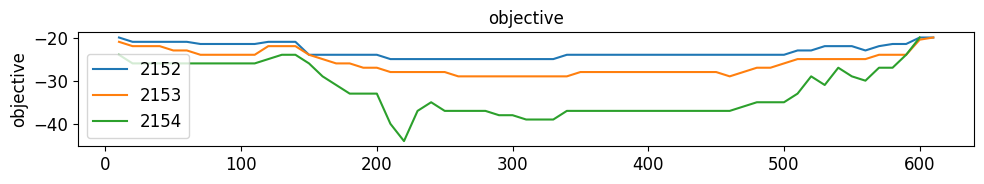

In [20]:
objective_changes = {}
for series in serieses:
    objective_changes[series] = {}
    # print(50 * "-" + f" {series} " + 50 * "-")
    objective_changes[series]["objective"] = series_changes[series]["objective"]
    # draw_temporal(objective_changes[series], adaptation_interval=adaptation_intervals[series])
ylabel = "objective"
draw_temporal(
    objective_changes, adaptation_intervals, multiple_experiments=True, ylabel=ylabel
)
# draw_cumulative(objective_changes, multiple_experiments=True, ylabel=ylabel)

## timeouts

2 out of 11197
1564 out of 22699
7202 out of 45687


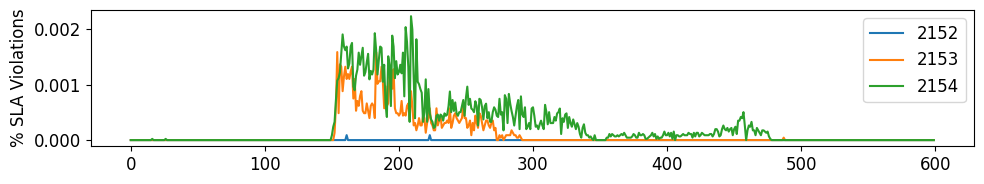

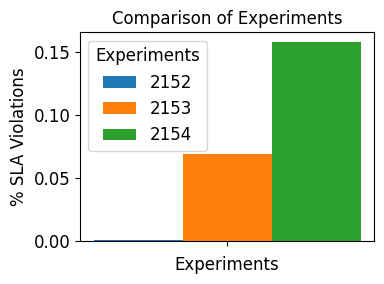

In [21]:
import numpy as np

if not all(simulation_modes.values()):
    ylabel = "% SLA Violations"
    xlabel = "Experiments"
    timeout_dics = {}
    for series in serieses:
        # print(50 * "-" + f" {series} " + 50 * "-")
        if not simulation_modes[series]:
            timeout_dics[series] = {
                "": (
                    np.array(timeout_per_second[series]) / sum(sent_loads[series])
                ).tolist()
            }
            # draw_temporal(timeout_dics[series])
            print(f"{sum(timeout_per_second[series])} out of {sum(sent_loads[series])}")
    draw_temporal(timeout_dics, multiple_experiments=True, ylabel=ylabel)
    draw_cumulative(
        timeout_dics,
        multiple_experiments=True,
        ylabel=ylabel,
        series_names=series_names,
        xlabel=xlabel,
    )

In [22]:
for series in serieses:
    print(50 * "-" + f" {series} " + 50 * "-")
    for key, value in series_changes[series].items():
        if key == "nodes":
            for node_name, all_configs in value.items():
                print(f"node: {node_name}\n")
                for config_name, config_values in all_configs.items():
                    print(f"{config_name}: {config_values}")

-------------------------------------------------- 2152 --------------------------------------------------
node: yolo

cpu: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
replicas: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1]
batch: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
variant: ['yolov5n', 'yolov5s', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'yolov5n', 'y

# Paper ready figures

{2152: 10, 2153: 10, 2154: 10}
{2152: [5, 3, 5, 5, 7, 5, 4, 5, 7, 5, 4, 4, 4, 4, 6, 4, 4, 6, 4, 3, 6, 5, 6, 5, 5, 4, 4, 6, 5, 4, 6, 5, 6, 5, 6, 7, 7, 5, 5, 4, 7, 6, 6, 5, 4, 6, 6, 4, 6, 5, 4, 4, 4, 5, 5, 5, 3, 5, 5, 6, 8, 10, 7, 6, 5, 6, 6, 5, 6, 6, 4, 6, 6, 3, 7, 6, 6, 4, 6, 6, 5, 6, 6, 3, 7, 4, 5, 6, 6, 5, 5, 5, 5, 8, 5, 5, 6, 6, 5, 7, 7, 7, 7, 6, 4, 5, 5, 4, 6, 5, 5, 7, 5, 5, 6, 6, 5, 6, 5, 6, 5, 5, 5, 6, 5, 6, 5, 6, 5, 6, 5, 4, 5, 5, 6, 5, 5, 6, 4, 4, 5, 5, 5, 4, 4, 6, 6, 16, 15, 12, 12, 15, 15, 18, 21, 16, 21, 20, 22, 24, 24, 21, 23, 22, 23, 23, 27, 26, 22, 25, 24, 26, 26, 24, 23, 22, 27, 24, 23, 25, 26, 24, 26, 30, 27, 27, 28, 30, 27, 24, 24, 24, 24, 29, 27, 25, 29, 28, 27, 25, 26, 28, 33, 25, 27, 29, 27, 29, 27, 28, 28, 27, 26, 26, 27, 28, 26, 25, 29, 30, 24, 28, 27, 29, 26, 26, 25, 27, 31, 27, 26, 29, 24, 28, 27, 27, 28, 27, 31, 26, 28, 29, 31, 24, 28, 28, 29, 29, 33, 28, 27, 28, 26, 28, 27, 25, 27, 28, 26, 26, 29, 29, 28, 25, 27, 28, 28, 26, 25, 27, 30, 28, 31, 26, 29, 30, 27,

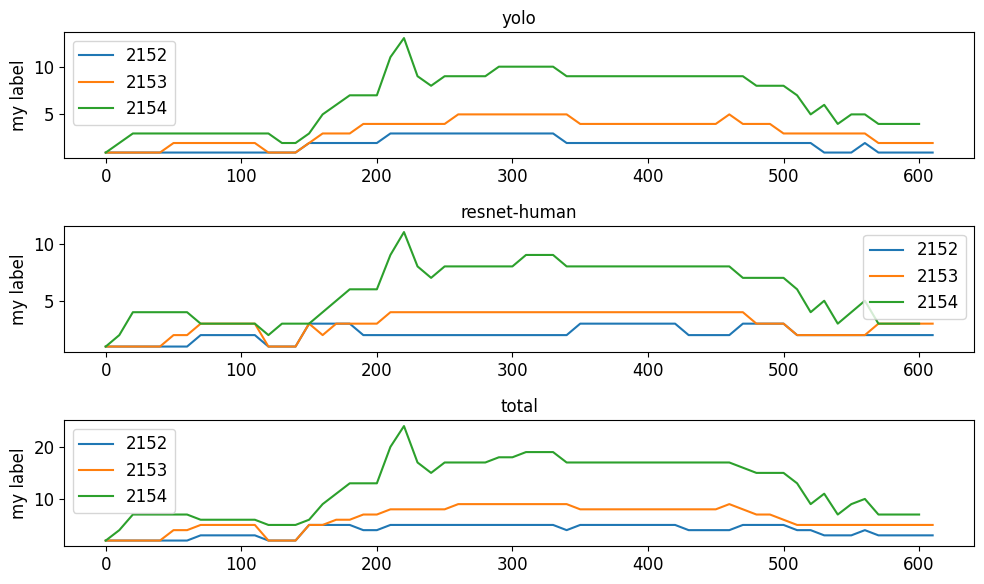

In [23]:
print(adaptation_intervals)

print(sent_loads)

print(recieved_load)

# print(replica_changes)

print(accuracy_changes)

print(total_core_changes)

draw_temporal(
    total_core_changes,
    adaptation_intervals,
    ylabel="my label",
    multiple_experiments=True,
)

In [24]:
def draw_temporal_paper(
    dict_to_draw: Dict[str, Dict[str, List[int]]],
    adaptation_interval=None,
    ylabel="Value",
    multiple_experiments=False,
):
    if not multiple_experiments:
        num_keys = len(dict_to_draw.keys())
        x_values = range(len(list(dict_to_draw.values())[0]))
        if num_keys > 1:
            fig, axs = plt.subplots(nrows=num_keys, ncols=1, figsize=(10, num_keys * 2))
            if adaptation_interval is not None:
                x_values = [item * adaptation_interval for item in list(x_values)]
            for i, key in enumerate(dict_to_draw.keys()):
                axs[i].plot(x_values, dict_to_draw[key], label=key)
                axs[i].set_title(key)
                axs[i].set_ylabel(ylabel=ylabel)
                axs[i].legend()
        else:
            fig, axs = plt.subplots(figsize=(10, num_keys * 2))
            key = list(dict_to_draw.keys())[0]
            axs.plot(x_values, dict_to_draw[key], label=key)
            axs.set_title(key)
            axs.set_ylabel(ylabel=ylabel)
            axs.legend()

    else:
        sample_dict_item_key = list(dict_to_draw.keys())[0]
        sample_dict_item = dict_to_draw[sample_dict_item_key]
        keys_to_draw = sample_dict_item.keys()
        num_keys = len(keys_to_draw)
        if num_keys > 1:
            fig, axs = plt.subplots(nrows=num_keys, ncols=1, figsize=(10, num_keys * 2))
            for i, key in enumerate(sample_dict_item.keys()):
                for experiment_id, dict_to_draw_exp in dict_to_draw.items():
                    x_values = range(len(list(dict_to_draw_exp.values())[0]))
                    if adaptation_interval is not None:
                        x_values = [
                            item * adaptation_interval[experiment_id]
                            for item in list(x_values)
                        ]
                    axs[i].plot(x_values, dict_to_draw_exp[key], label=experiment_id)
                    axs[i].set_title(key)
                    axs[i].set_ylabel(ylabel=ylabel)
                    axs[i].legend()
        else:
            fig, axs = plt.subplots(figsize=(10, num_keys * 2))
            for i, key in enumerate(sample_dict_item.keys()):
                for experiment_id, dict_to_draw_exp in dict_to_draw.items():
                    x_values = range(len(list(dict_to_draw_exp.values())[0]))
                    if adaptation_interval is not None:
                        x_values = [
                            item * adaptation_interval[experiment_id]
                            for item in list(x_values)
                        ]
                    axs.plot(x_values, dict_to_draw_exp[key], label=experiment_id)
                    axs.set_title(key)
                    axs.set_ylabel(ylabel=ylabel)
                    axs.legend()

    plt.tight_layout()
    plt.show()

In [25]:
"""
1. Temporal could be on the showing both nodes
2. 
"""

'\n1. Temporal could be on the showing both nodes\n2. \n'